In [142]:
# Importieren der Notwendigen Bibliotheken und Funktionen
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from torch import nn
import timm
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [143]:
# Angeben einiger allgemeiner Daten
# DATASET 1 pfad/directory
dataset_train_dir = os.path.join('dataset_generiert_kreis-vs-strich', 'train')
#dataset_val_dir = os.path.join('dataset_generiert', 'val')  # Falls man getrennten Ordner hat statt später abzusplittenc

# DATASET 2
dataset_train_dir = os.path.join('dataset_generiert_robin_29-7_satte_Schlange', 'train')

# DATASET 3
#dataset_train_dir = os.path.join('dataset_real', 'train')  # Hier sind reale Bilder von Beulen zu finden

# DATASET Bonus
#dataset_train_dir = os.path.join('dataset_katzen', 'train')  # Hier sind herunter geladene Bilder

In [144]:
# Festlegen einiger Hyperparameter
learning_rate = 0.001  # Ähnlich wie bei linearer Regression ist das die Länge des Weges dem man dem Gradienten folgt um das Minimum zu finden
weight_decay = 0.0  # Vergessens Parameter um ein überfitten / auswendig-lernen der Trainingsdaten zu verhindern, ist vor allem bei kleinen Datensets und einfachen Problemen nötig
#dropout_rate = 0.0  # Alternative zum Weightdecay, löscht inhalte von Neuronen komplett mit bestimmter Wahrscheinlichkeit, hier erstmal nicht genutzt
batch_size = 16  # Menge der Daten die Gleichzeitig durch das Netz geschickt werden, hat Einfluss auf die Verarbeitungsgeschwindigkeit (gilt unter diesem Gesichtspunkt ein Wert der weder zu hoch noch zu niedrig ist als optimal) ist bei moderneren Netzen aber auch einen Einfluss auf die Qulität des lernens vorhanden (größer ist da besser wegen Batchnormlayers)

num_classes = 2 # Anzahl der Outputklassen / Outputneuronen
new_image_size = (60, 60)  # Größe der Bilder in Pixel
means = torch.tensor([0.75, 0.75, 0.75])  # Normalisierung der Bilder mit diesem Mittelwert für die RGB-Kanäle
stds = torch.tensor([0.3, 0.3, 0.3])  # Normalisierung mit dieser Standardabweichung
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Überprüft ob neben der CPU über CUDA auch Zugriff auf die Grafikkarte besteht für schnellere Berechnungen 
print('Device avaiable:', device)
#device = 'cpu'

Device avaiable: cuda


Bild Nr 4: Klassennummer: 0


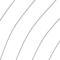

Gesamtanzahl im Datenset: 2158
Vorhandene Klassen und ihre Nummern: {'0_negatives': 0, '1_positive_beulen': 1}


In [146]:
# Einlesen und Vorbereiten der Daten

# Die Daten können mit Augmentation versehen werden, beispielsweise kann ihre Größe, ihr Winkel ect.. geändert werden
# Bildergröße und Umwandeln in Tensor ist Pflicht, andere Augmentationen können dem Netz helfen allgemeinere Dinge zu lernen, wie Spiegel-, Winkelunabhängigkeit und können entsprechend zu und abgeschaltet werden
train_augs = T.Compose([T.Resize(size = new_image_size),
                        # Einige Bildaugmentationen die man später nach belieben aktivieren und testen kann
                        #T.RandomRotation(degrees=(-45,+45) ), # in degree
                        #T.RandomCrop(new_img_size, padding=0, padding_mode='constant'),  # erweitert Bild mit Padding und schneidet dann ein Stück der Größe vorne angegeben aus
                        T.RandomHorizontalFlip(p=0.5),
                        #T.RandomVerticalFlip(p=0.5),
                        #T.RandomPerspective(distortion_scale=0.05, p=0.4),
                        #T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1), # from 0-1
                        T.ToTensor(),  # umwandeln in Tensor
                        T.Normalize(mean = means, std = stds)
                      ])

unnormalize_trans = T.Normalize((-means / stds).tolist(), (1.0 / stds).tolist())  # Fürs Rückstransformieren in für menschen verständliches Bild

# Je nach Anwendung ist es erforderlich seine eigene Datasetklassen zu schreiben, für diese Klassifizierungsaufgabe soll aber die Standardfunktion aussreichen
dataset_train = ImageFolder(dataset_train_dir, transform = train_augs)
# Objekte des Typs Dataset können mit eckigen Klammern direkt ein Element und sein Label liefern oder der Reihe nach in einer Schleife iteriert werden.

# Testen der Bilder und Augmentationen
nummer = 4  # Ruhig ändern wird das entsprechende Bild mit dieser Nummer rauspicken und anzeigen
img, label = dataset_train[nummer]  # rauspicken aus Datensets
# Für Menschen wieder lesbar machen:
img_unn = (np.transpose(unnormalize_trans(img.cpu().detach()).numpy(), (1, 2, 0)))
img_unn = Image.fromarray((img_unn * 255).astype(np.uint8))
print(f"Bild Nr {nummer}: Klassennummer: {label}")
display(img_unn)  # Anzeigen lassen

# Alternativ kann man auch über das Datenset iterieren der Form: for img, label in dadaset_train:
# Zusätzlich kann man sich auch die Anzahl der Elemente im Datenset anzeigen lassen:
print('Gesamtanzahl im Datenset:', len(dataset_train))

print(f"Vorhandene Klassen und ihre Nummern: {dataset_train.class_to_idx}")

In [147]:
# Splitten des Datasets
# Dem Netz alle Daten zu zeigen wäre in etwa so klug einem Schüler nicht nur die Übungsaufgaben sondern auch die Prüfungsaufgaben zu zeigen.
# Es bestünde die Gefahr dass der Schüler die richtigen Antworten einfach auswendig lernt statt eine komplexere Logik zu lernen und man es nicht merkt.
# Deswegen gibt es stets ein Validationsset, dieses Set wird nicht zum direkten Training verwendet sondern nur zum genaueres Überprüfen des Trainingfortschritts
valid_fraction = 0.1  # Anteil des Datensets welches abgespalten wird ins Validationsset
total_num = len(dataset_train)
valid_num = int(total_num*valid_fraction)
train_num = total_num - valid_num # Absolute Anzahl von Daten die in den jeweiligen Sets landen sollen
dataset_train, dataset_val = random_split(dataset_train, [train_num, valid_num]) # Zufälliges Aufteilen der Daten in Trainings- und Validationssets

In [148]:
# Erstellen des Dataloaders hier übergeben wir das Datenset
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=3)
# Der Dataloader ist eine Klasse die zum Verwalten der Datensets genutzt wird. Er teilt die Daten auch in die handlichen Batches ein die ins model gefüttert werden können
# Er hat zusätzlich auch ähnliche Eigenschaften wie das Datenset, man kann auch über den Dataloader Iterieren oder seine Länge ausgeben lassen, allerdings sind hier die batches die kleinste Einheit
# Test
print(f"Länge der Dataloader train {len(train_loader)}, val {len(val_loader)}")
print(f"Länge der Dataloader mal batchsize train {len(train_loader)*batch_size}, val {len(val_loader)*batch_size}")

Länge der Dataloader train 122, val 14
Länge der Dataloader mal batchsize train 1952, val 224


In [149]:
# Erstellen der neuronalen Netze
# Hier werden 3 verschiedene Netze vorgestellt

# 1 Selbst geschriebenes : Einfaches Dense Model

class DenseNet(torch.nn.Module):
    def __init__(self, neuron_list, dropout_rate = 0):
        super(DenseNet, self).__init__()
        #self.loss = F.binary_cross_entropy()  #
        self.loss = nn.CrossEntropyLoss()
        self.drop_out_rate = 0
        
        # Erstellen der Dense Layers
        self.fc = nn.Sequential(nn.Linear(neuron_list[0], neuron_list[1]),
                        nn.ReLU(),
                        nn.Dropout(p=self.drop_out_rate),
                        nn.Linear(neuron_list[1], neuron_list[2]),
                        nn.ReLU(),
                        nn.Dropout(p=self.drop_out_rate),
                        nn.Linear(neuron_list[2], neuron_list[3])
                    )
    # Wie die Layer auszuführen oder zu durchlaufen sind
    def forward(self, x, labels = None):
        #print(x.shape)
        x = x.reshape(x.shape[0], -1)  # flatten 2d Image to 1d vector, da Denselayers auf 1d arbeiten 
        #print(x.shape)
        x = self.fc(x)  # Anwenden der Denselayers deren Liste oben erstellt wurde
        return x


# 2 Selbst geschriebenes : Einfaches Convolution Model, es besteht hinten wieder aus Dense Layers, vorher wird das Bild aber mit Convolutions und pooling in den Raumdimensionen reduziert aber die Anzahl der Kanäle erhöht

class ConvNet(torch.nn.Module):
    def __init__(self, channels, neuron_list, dropout_rate = 0):
        super(ConvNet, self).__init__()
        self.loss = nn.CrossEntropyLoss()

        self.channels = channels
        self.neuron_list = neuron_list

        self.conv = nn.Sequential(
        nn.Conv2d(in_channels=self.channels[0], out_channels=self.channels[1], kernel_size=3, bias=False, stride=1, padding=1),
        nn.BatchNorm2d(self.channels[1]),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
            
        nn.Conv2d(in_channels=self.channels[1], out_channels=self.channels[2], kernel_size=3, bias=False, stride=1, padding=1),
        nn.BatchNorm2d(self.channels[2]),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        )
        
        self.fc = nn.Sequential(nn.Linear(self.neuron_list[0], self.neuron_list[1]),
                        nn.ReLU(),
                        nn.Dropout(p=0.0),
                        nn.Linear(self.neuron_list[1], self.neuron_list[2]),
                        nn.ReLU(),
                        nn.Dropout(p=0.0),
                        nn.Linear(self.neuron_list[2], self.neuron_list[3])
                    )

                                
    def forward(self, images, labels = None):
        #x = self.conv_layers(images)
        x = self.conv(images)  # durchs pooling halbiert sich jedesmal die Größe
        #print('Vor reshape', x.shape)
        x = x.reshape(x.shape[0], -1)  # flatten 2d Image to 1d vector
        #print('Vor Dense-layers', x.shape)
        x = self.fc(x)  # Anwenden der Flattlayers
        return x


# 3 Vorgefertigte Klassen können beispielweise aus der Bibliothek Timm importiert werden
# Viele modernere Netze sind auf Auflösung 224 aufwärts optimiert sollten aber auch halbwegs gute Ergebnisse mit kleineren Auflösungen liefern


class TimmModel(torch.nn.Module):
    def __init__(self, timm_model_name, dropout_rate = 0):
        super(TimmModel, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.net = timm.create_model(timm_model_name, pretrained = False, num_classes = num_classes, drop_rate=dropout_rate)

    def forward(self, images, labels = None):
        logits = self.net(images)
        return logits

In [150]:
# 1 Einfaches DenseNet
# Denselayers sind einfach nur Matrixmultiplikationen, die Größe ergibt sich aus der Vorgänger Dimension und der gewünschten Neuronenzahl in der aktuellen Dimension
# Die erste Dimension ist durch die Anzahl der beiden Pixeldimensionen mal der 3 Farbkanäle gegeben, die letzte durch die Zahl der möglichen Ergebnisse
neuron_list = np.array([60*60*3, 512, 64, 2])  # Eingabeebene - diverse Neuron Ebenen - Ausgabeebene
#neuron_list = np.array([60*60*3, 64, 32, 2])
model = DenseNet(neuron_list)


# 2 Simples ConvNets
channel_list = [3, 32, 64]  # Meist erhöht man die Kanalzahl während die Convolutions die Bildgröße reduzieren
neuron_list = [int(60*60/4/4*64), 1024, 64, 2]  # Die erste Neuronenzahl der Dense-Layers ist durch den Output aus dem Convolution-Layers vorgeben. Die 2 Convolutionblöcke halbierne die Bildgröße von 60*60, zweimal in X und Y Dimension, Allerdings wurde Kanalzahl dann von 3 auf 64 erhöht. Die folgenden Neuronenzahlen können frei gewählt werden. Nur für den Output sollten es dann wieder 2 sein.
model = ConvNet(channel_list, neuron_list)

#test_tensor = torch.randn([1, 3, 60, 60])
#model(test_tensor)


# 3 Timm Model
timm_model_name = 'resnet18' # einige Namensvorschläge: 'resnet18' 'resnet34' 'resnet50' 'vgg11' 'vgg13' 'vgg16' 'inception_resnet_v2' 'inception_v3, 'inception_v4'
#model = TimmModel(timm_model_name, dropout_rate=0)


#Der Optimizer errechnet Gradienten und verwaltet Gewichte eines NN / models, der Adam Optimzer steht beispielsweise für eine adaptive Learningrate
model = model.to(device)  # Model auf Grafikkarte verschieben sofern möglich

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [151]:
# Ansehen / Überprüfen der Modelebenen, hier kann standardmäßig die Printfunktion genutzt werden, in Python wird in __str__
print(model)

ConvNet(
  (loss): CrossEntropyLoss()
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc): Sequential(
    (0): Linear(in_features=14400, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=1024, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [152]:
# Training Loop
epochs = 25  # Anzahl wie oft alle Daten dem Netz gezeigt werden
progressbar = tqdm(range(epochs), total=epochs, desc="Epochs")
loss_train_list = []  # zum speichern des loss über die epochen
acc_train_list = []  # zum speichern der accuracy über die epochen
loss_val_list = []
acc_val_list = []
for epoch in progressbar:
    total_train_loss = 0
    total_train_acc = 0
    
    for batch in train_loader:
        imgs, labels = batch  # nimmt die Bilder und Label aus dem Batch
        imgs = imgs.to(device=device)  # Senden des img batches an die Grafikkarte sofern möglich
        labels = labels.to(device=device)  # ""
        
        
        results = model(imgs)  # Ergebnis des models für den batch
        loss = model.loss(results, labels)  # Errechnet den loss
        
        # Optimizer Schritte
        optimizer.zero_grad()  # Nullen der Gradienten
        loss.backward()  # Errechnen der neuen Gradienten
        optimizer.step()  # Update der Gewichte
        
        top_p,top_class = results.topk(1,dim = 1) # Klasse mit höchsten Wert
        equals = top_class == labels.view(*top_class.shape) # Wenn gleich dann True dann = 1, sonst 0 (wird für Vergleich reshaped)
        acc = torch.mean(equals.type(torch.FloatTensor))  # Mittelwert der 0 und 1 errechnen
        #print('acc', acc)
        
        total_train_loss += loss.item()  # Addiert den loss über alle batches auf, um später den durchschnittlichen Loss zur Bewertung zu ermitteln       
        total_train_acc += acc.item()
        #break
    del imgs, labels  # löschen um Grafikspeichern frei zu geben, da sie nach dem Ende der Schleifen nicht mehr überschrieben werden
    final_train_loss = total_train_loss / len(train_loader)
    loss_train_list.append(final_train_loss)
    
    final_train_acc = total_train_acc / len(train_loader)
    acc_train_list.append(final_train_acc)

    print('Train loss', final_train_loss, 'Train acc', final_train_acc)
    

    total_val_loss = 0
    total_val_acc = 0    
    with torch.no_grad():  # Gradienten Ermittlung für Validation unnötig/gesperrt
        for batch in val_loader:
            imgs, labels = batch
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            results = model(imgs)
            loss = model.loss(results, labels)
            
            top_p,top_class = results.topk(1,dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            acc = torch.mean(equals.type(torch.FloatTensor))
            #print('accuracy', acc)
            
            total_val_loss += loss.item()
            total_val_acc +=acc.item()
            
        del imgs, labels
        final_val_loss = total_val_loss / len(val_loader)
        loss_val_list.append(final_val_loss)

        final_val_acc = total_val_acc / len(val_loader)
        acc_val_list.append(final_val_acc)

        print('Val loss', final_val_loss, 'Val acc', final_val_acc)

Epochs:   0%|                                                                                   | 0/25 [00:00<?, ?it/s]

Train loss 0.6944569107450422 Train acc 0.6380269322238985


Epochs:   4%|███                                                                        | 1/25 [00:10<04:22, 10.92s/it]

Val loss 0.6476509038891111 Val acc 0.6938775522368295
Train loss 0.5049506699452635 Train acc 0.7570257611939164


Epochs:   8%|██████                                                                     | 2/25 [00:21<04:11, 10.93s/it]

Val loss 0.5379101027335439 Val acc 0.7519132665225438
Train loss 0.415920760177198 Train acc 0.8104508196721312


Epochs:  12%|█████████                                                                  | 3/25 [00:32<04:01, 10.97s/it]

Val loss 0.38898734588708195 Val acc 0.8233418379511152
Train loss 0.320550018829889 Train acc 0.871267564472605


Epochs:  16%|████████████                                                               | 4/25 [00:44<03:51, 11.04s/it]

Val loss 0.3413841367832252 Val acc 0.8647959189755576
Train loss 0.28162696841554563 Train acc 0.8878073770491803


Epochs:  20%|███████████████                                                            | 5/25 [00:55<03:40, 11.03s/it]

Val loss 0.39725629346711294 Val acc 0.7933673475469861
Train loss 0.24447898072053176 Train acc 0.9030298595545722


Epochs:  24%|██████████████████                                                         | 6/25 [01:06<03:31, 11.12s/it]

Val loss 0.30101803158010754 Val acc 0.8692602046898433
Train loss 0.17417459744105085 Train acc 0.9271077284070312


Epochs:  28%|█████████████████████                                                      | 7/25 [01:17<03:19, 11.07s/it]

Val loss 0.22993094261203492 Val acc 0.90625
Train loss 0.167508850637518 Train acc 0.9364754098360656


Epochs:  32%|████████████████████████                                                   | 8/25 [01:28<03:06, 10.99s/it]

Val loss 0.2098423603123852 Val acc 0.9228316332612719
Train loss 0.1498930808691094 Train acc 0.9465749415217853


Epochs:  36%|███████████████████████████                                                | 9/25 [01:39<02:57, 11.10s/it]

Val loss 0.24447034592075007 Val acc 0.8813775522368295
Train loss 0.14441723576517868 Train acc 0.9487704918032787


Epochs:  40%|█████████████████████████████▌                                            | 10/25 [01:50<02:47, 11.20s/it]

Val loss 0.1909497970316027 Val acc 0.9139030618327004
Train loss 0.10787479809607517 Train acc 0.9626024590163934


Epochs:  44%|████████████████████████████████▌                                         | 11/25 [02:01<02:36, 11.16s/it]

Val loss 0.1607735078515751 Val acc 0.9317602046898433
Train loss 0.08980650747706351 Train acc 0.9636270491803278


Epochs:  48%|███████████████████████████████████▌                                      | 12/25 [02:12<02:24, 11.13s/it]

Val loss 0.35049267512347015 Val acc 0.8858418379511152
Train loss 0.0820736153037898 Train acc 0.9707991803278688


Epochs:  52%|██████████████████████████████████████▍                                   | 13/25 [02:23<02:12, 11.01s/it]

Val loss 0.26405895221978426 Val acc 0.8839285714285714
Train loss 0.08885622267290706 Train acc 0.9667008196721312


Epochs:  56%|█████████████████████████████████████████▍                                | 14/25 [02:34<02:00, 10.98s/it]

Val loss 0.23912535927125386 Val acc 0.9139030618327004
Train loss 0.05590608244481283 Train acc 0.9784836065573771


Epochs:  60%|████████████████████████████████████████████▍                             | 15/25 [02:45<01:50, 11.01s/it]

Val loss 0.13395056283167964 Val acc 0.9508928571428571
Train loss 0.0372243385888888 Train acc 0.9892418032786885


Epochs:  64%|███████████████████████████████████████████████▎                          | 16/25 [02:56<01:38, 10.99s/it]

Val loss 0.21494298029158795 Val acc 0.9272959189755576
Train loss 0.06736513171569238 Train acc 0.9774590163934426


Epochs:  68%|██████████████████████████████████████████████████▎                       | 17/25 [03:07<01:27, 10.98s/it]

Val loss 0.1268120451298143 Val acc 0.9496173475469861
Train loss 0.05110989020255654 Train acc 0.9789959016393442


Epochs:  72%|█████████████████████████████████████████████████████▎                    | 18/25 [03:18<01:16, 10.93s/it]

Val loss 0.161734560970217 Val acc 0.9553571428571429
Train loss 0.037785182292282116 Train acc 0.9861680327868853


Epochs:  76%|████████████████████████████████████████████████████████▏                 | 19/25 [03:29<01:05, 10.98s/it]

Val loss 0.2659210304596594 Val acc 0.9183673475469861
Train loss 0.031070952428233826 Train acc 0.9871926229508197


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 20/25 [03:40<00:54, 10.95s/it]

Val loss 0.18477461414087365 Val acc 0.9406887761184147
Train loss 0.032594801066180915 Train acc 0.9902663934426229


Epochs:  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [03:51<00:43, 10.92s/it]

Val loss 0.14207877739681862 Val acc 0.9375
Train loss 0.026831820809212467 Train acc 0.9923155737704918


Epochs:  88%|█████████████████████████████████████████████████████████████████         | 22/25 [04:02<00:32, 10.93s/it]

Val loss 0.12428002867714635 Val acc 0.9464285714285714
Train loss 0.032842577552356325 Train acc 0.9877049180327869


Epochs:  92%|████████████████████████████████████████████████████████████████████      | 23/25 [04:13<00:21, 10.90s/it]

Val loss 0.12838876668008328 Val acc 0.9642857142857143
Train loss 0.04452912431153264 Train acc 0.9846311475409836


Epochs:  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [04:24<00:10, 10.97s/it]

Val loss 0.24730681411788932 Val acc 0.9304846950939724
Train loss 0.03926405612827559 Train acc 0.9897540983606558


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [04:35<00:00, 11.01s/it]

Val loss 0.17876933658096408 Val acc 0.936224490404129


Text(0.5, 0, 'Epochs')

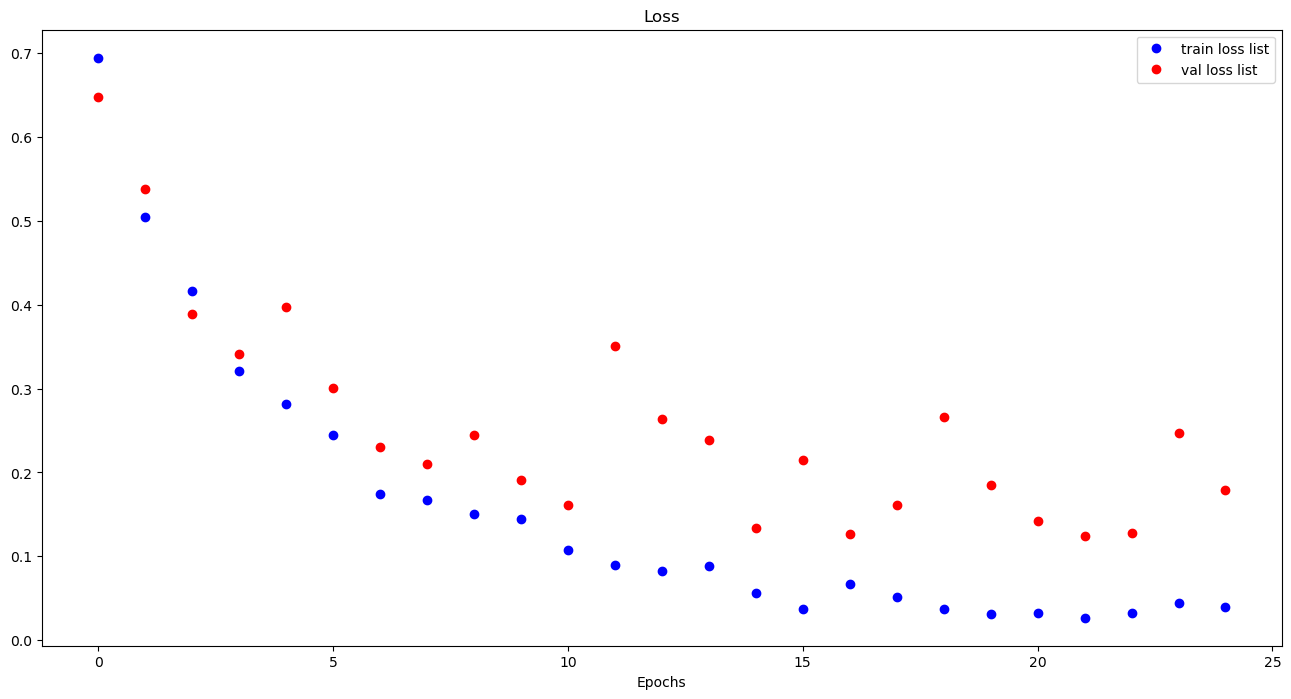

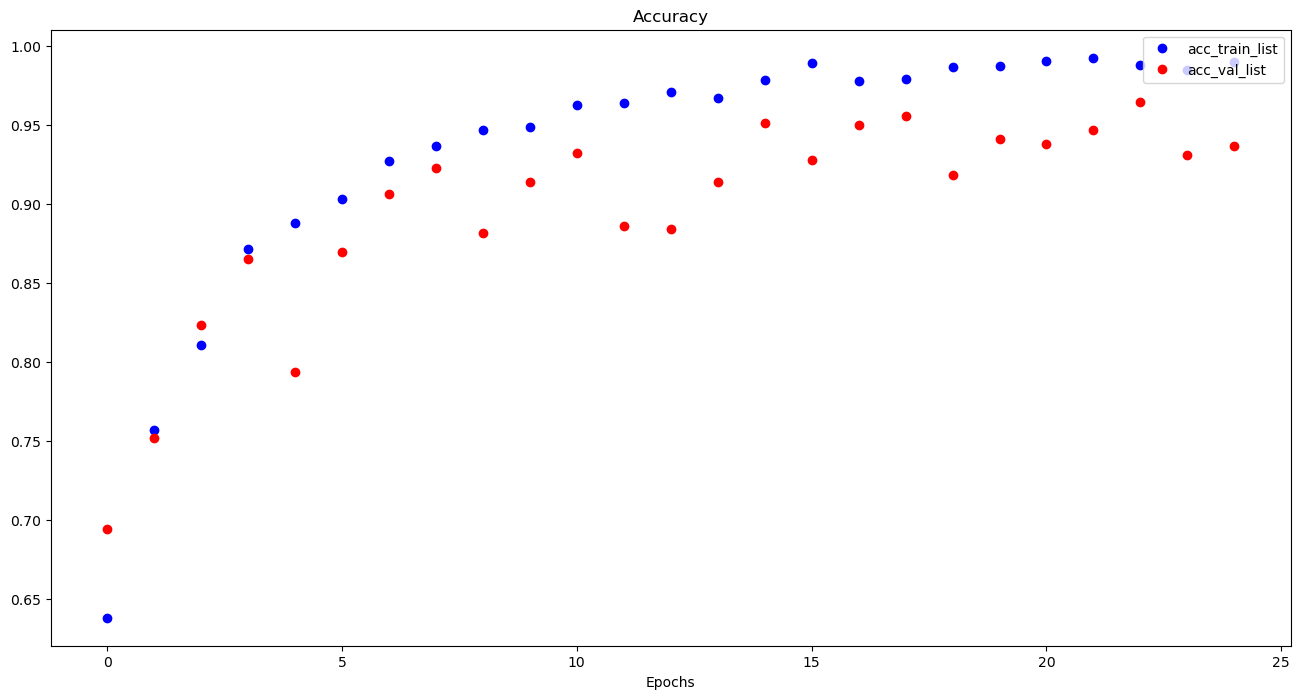

In [154]:
#print('train loss list', loss_train_list)
#print('val loss list', loss_val_list)

plt.figure(figsize=(16,8))
plt.title('Loss')
plt.plot(range(len(loss_train_list)), (loss_train_list), 'bo')
plt.plot(range(len(loss_val_list)), (loss_val_list), 'ro')
plt.legend(['train loss list', 'val loss list'], loc ="upper right")
plt.xlabel('Epochs')
#plt.ylim(0.95, 1)

plt.figure(figsize=(16,8))
plt.title('Accuracy')
plt.plot(range(len(acc_train_list)), (acc_train_list), 'bo')
plt.plot(range(len(acc_val_list)), (acc_val_list), 'ro')
plt.legend(['acc_train_list', 'acc_val_list'], loc ="upper right")
plt.xlabel('Epochs')

Predicted Label: 1, Real label 1
Probability for class 1: 0.9981


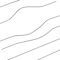

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


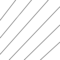

Predicted Label: 0, Real label 0
Probability for class 1: 0.0095


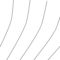

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


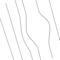

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


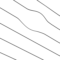

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


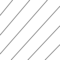

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


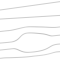

Predicted Label: 1, Real label 1
Probability for class 1: 0.9997


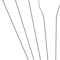

Predicted Label: 0, Real label 0
Probability for class 1: 0.0054


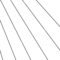

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


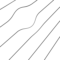

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


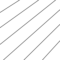

Predicted Label: 0, Real label 0
Probability for class 1: 0.0041


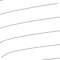

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


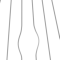

Predicted Label: 0, Real label 0
Probability for class 1: 0.1449


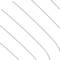

Predicted Label: 0, Real label 0
Probability for class 1: 0.0207


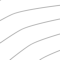

Predicted Label: 1, Real label 0
Probability for class 1: 0.9998


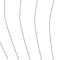

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


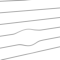

Predicted Label: 0, Real label 0
Probability for class 1: 0.005


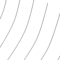

Predicted Label: 1, Real label 1
Probability for class 1: 0.9999


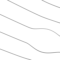

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


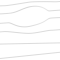

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


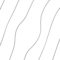

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


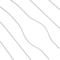

Predicted Label: 0, Real label 0
Probability for class 1: 0.0002


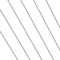

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


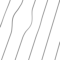

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


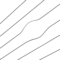

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


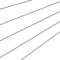

Predicted Label: 1, Real label 1
Probability for class 1: 0.9939


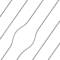

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


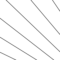

Predicted Label: 0, Real label 0
Probability for class 1: 0.002


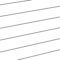

Predicted Label: 1, Real label 1
Probability for class 1: 0.992


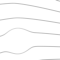

Predicted Label: 0, Real label 0
Probability for class 1: 0.0008


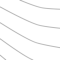

Predicted Label: 0, Real label 0
Probability for class 1: 0.0036


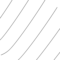

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


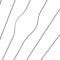

Predicted Label: 1, Real label 1
Probability for class 1: 0.5533


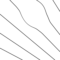

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


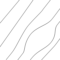

Predicted Label: 1, Real label 0
Probability for class 1: 0.9125


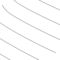

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


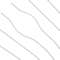

Predicted Label: 0, Real label 0
Probability for class 1: 0.0004


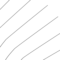

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


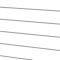

Predicted Label: 0, Real label 0
Probability for class 1: 0.0029


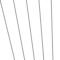

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


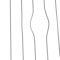

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


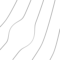

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


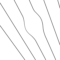

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


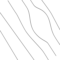

Predicted Label: 0, Real label 0
Probability for class 1: 0.0008


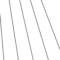

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


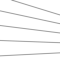

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


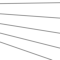

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


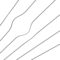

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


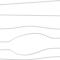

Predicted Label: 0, Real label 0
Probability for class 1: 0.0002


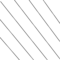

Predicted Label: 0, Real label 0
Probability for class 1: 0.0006


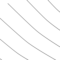

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


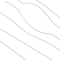

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


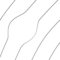

Predicted Label: 1, Real label 1
Probability for class 1: 0.9999


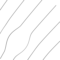

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


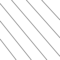

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


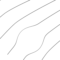

Predicted Label: 1, Real label 1
Probability for class 1: 0.9888


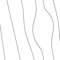

Predicted Label: 0, Real label 0
Probability for class 1: 0.0003


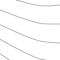

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


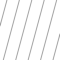

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


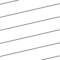

Predicted Label: 1, Real label 1
Probability for class 1: 0.975


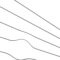

Predicted Label: 1, Real label 1
Probability for class 1: 0.9999


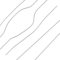

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


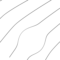

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


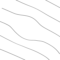

Predicted Label: 0, Real label 0
Probability for class 1: 0.0256


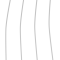

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


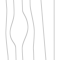

Predicted Label: 0, Real label 0
Probability for class 1: 0.0035


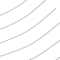

Predicted Label: 1, Real label 1
Probability for class 1: 0.9979


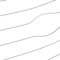

Predicted Label: 1, Real label 1
Probability for class 1: 0.9999


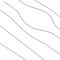

Predicted Label: 0, Real label 1
Probability for class 1: 0.2397


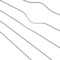

Predicted Label: 0, Real label 0
Probability for class 1: 0.0003


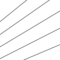

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


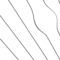

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


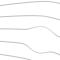

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


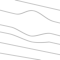

Predicted Label: 1, Real label 1
Probability for class 1: 0.9993


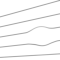

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


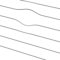

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


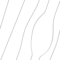

Predicted Label: 0, Real label 0
Probability for class 1: 0.0007


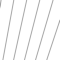

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


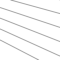

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


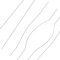

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


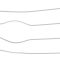

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


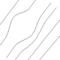

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


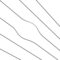

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


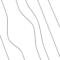

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


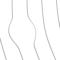

Predicted Label: 1, Real label 1
Probability for class 1: 0.8543


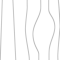

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


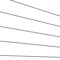

Predicted Label: 0, Real label 0
Probability for class 1: 0.0008


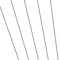

Predicted Label: 0, Real label 0
Probability for class 1: 0.0005


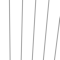

Predicted Label: 0, Real label 0
Probability for class 1: 0.001


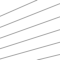

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


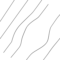

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


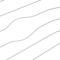

Predicted Label: 0, Real label 0
Probability for class 1: 0.001


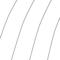

Predicted Label: 1, Real label 1
Probability for class 1: 0.6652


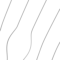

Predicted Label: 0, Real label 0
Probability for class 1: 0.0058


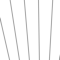

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


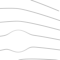

Predicted Label: 1, Real label 0
Probability for class 1: 0.8973


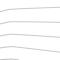

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


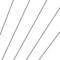

Predicted Label: 0, Real label 0
Probability for class 1: 0.3121


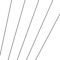

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


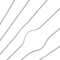

Predicted Label: 0, Real label 0
Probability for class 1: 0.0004


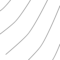

Predicted Label: 1, Real label 1
Probability for class 1: 0.9993


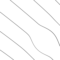

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


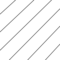

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


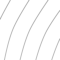

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


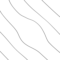

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


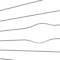

Predicted Label: 0, Real label 0
Probability for class 1: 0.0004


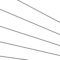

Predicted Label: 0, Real label 1
Probability for class 1: 0.4196


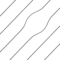

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


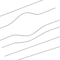

Predicted Label: 0, Real label 0
Probability for class 1: 0.0441


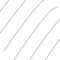

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


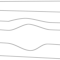

Predicted Label: 0, Real label 0
Probability for class 1: 0.0087


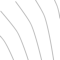

Predicted Label: 1, Real label 1
Probability for class 1: 0.9999


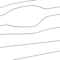

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


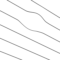

Predicted Label: 0, Real label 0
Probability for class 1: 0.0004


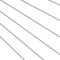

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


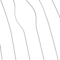

Predicted Label: 0, Real label 0
Probability for class 1: 0.1333


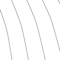

Predicted Label: 1, Real label 0
Probability for class 1: 0.5525


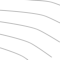

Predicted Label: 0, Real label 0
Probability for class 1: 0.0017


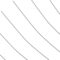

Predicted Label: 0, Real label 0
Probability for class 1: 0.0036


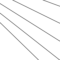

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


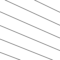

Predicted Label: 0, Real label 0
Probability for class 1: 0.0006


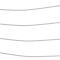

Predicted Label: 0, Real label 0
Probability for class 1: 0.0014


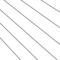

Predicted Label: 1, Real label 1
Probability for class 1: 0.9896


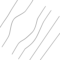

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


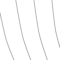

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


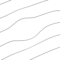

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


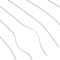

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


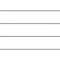

Predicted Label: 0, Real label 0
Probability for class 1: 0.0005


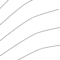

Predicted Label: 0, Real label 0
Probability for class 1: 0.0063


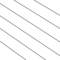

Predicted Label: 1, Real label 1
Probability for class 1: 0.9997


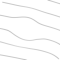

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


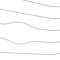

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


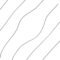

Predicted Label: 1, Real label 1
Probability for class 1: 0.9826


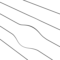

Predicted Label: 0, Real label 0
Probability for class 1: 0.0002


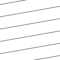

Predicted Label: 1, Real label 0
Probability for class 1: 0.5144


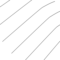

Predicted Label: 0, Real label 0
Probability for class 1: 0.0098


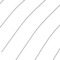

Predicted Label: 1, Real label 1
Probability for class 1: 0.9999


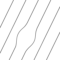

Predicted Label: 0, Real label 0
Probability for class 1: 0.329


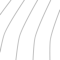

Predicted Label: 1, Real label 1
Probability for class 1: 0.9941


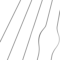

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


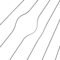

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


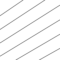

Predicted Label: 0, Real label 0
Probability for class 1: 0.0043


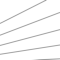

Predicted Label: 1, Real label 1
Probability for class 1: 0.9405


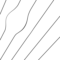

Predicted Label: 1, Real label 1
Probability for class 1: 0.6619


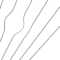

Predicted Label: 1, Real label 1
Probability for class 1: 0.9917


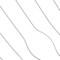

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


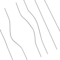

Predicted Label: 1, Real label 1
Probability for class 1: 0.8396


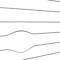

Predicted Label: 1, Real label 1
Probability for class 1: 0.9936


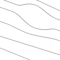

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


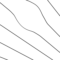

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


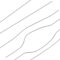

Predicted Label: 0, Real label 0
Probability for class 1: 0.0459


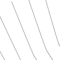

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


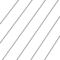

Predicted Label: 0, Real label 0
Probability for class 1: 0.0044


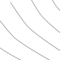

Predicted Label: 0, Real label 0
Probability for class 1: 0.0016


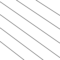

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


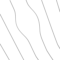

Predicted Label: 0, Real label 0
Probability for class 1: 0.0016


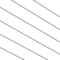

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


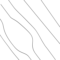

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


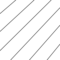

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


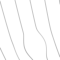

Predicted Label: 0, Real label 0
Probability for class 1: 0.007


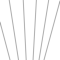

Predicted Label: 1, Real label 1
Probability for class 1: 0.5314


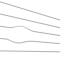

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


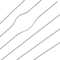

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


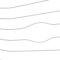

Predicted Label: 0, Real label 0
Probability for class 1: 0.0006


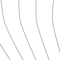

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


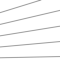

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


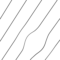

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


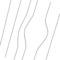

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


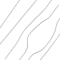

Predicted Label: 0, Real label 0
Probability for class 1: 0.0005


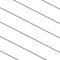

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


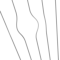

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


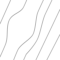

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


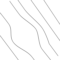

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


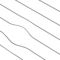

Predicted Label: 0, Real label 1
Probability for class 1: 0.092


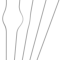

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


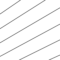

Predicted Label: 0, Real label 0
Probability for class 1: 0.1451


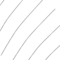

Predicted Label: 0, Real label 0
Probability for class 1: 0.093


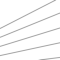

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


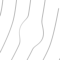

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


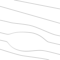

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


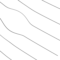

Predicted Label: 1, Real label 1
Probability for class 1: 0.9955


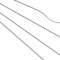

Predicted Label: 0, Real label 0
Probability for class 1: 0.0034


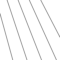

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


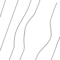

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


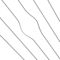

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


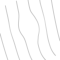

Predicted Label: 1, Real label 1
Probability for class 1: 0.9939


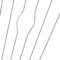

Predicted Label: 1, Real label 1
Probability for class 1: 0.8587


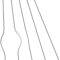

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


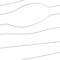

Predicted Label: 0, Real label 0
Probability for class 1: 0.0026


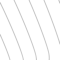

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


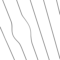

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


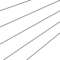

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


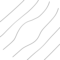

Predicted Label: 1, Real label 1
Probability for class 1: 0.9947


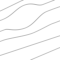

Predicted Label: 0, Real label 0
Probability for class 1: 0.0072


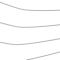

Predicted Label: 1, Real label 1
Probability for class 1: 0.9996


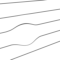

Predicted Label: 0, Real label 0
Probability for class 1: 0.1723


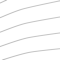

Predicted Label: 0, Real label 0
Probability for class 1: 0.0


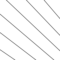

Predicted Label: 0, Real label 1
Probability for class 1: 0.0121


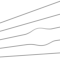

Predicted Label: 1, Real label 0
Probability for class 1: 0.8234


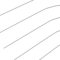

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


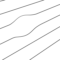

Predicted Label: 0, Real label 0
Probability for class 1: 0.0289


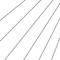

Predicted Label: 0, Real label 0
Probability for class 1: 0.0035


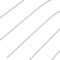

Predicted Label: 0, Real label 0
Probability for class 1: 0.0031


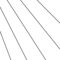

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


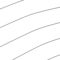

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


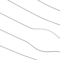

Predicted Label: 1, Real label 1
Probability for class 1: 0.751


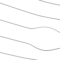

Predicted Label: 0, Real label 0
Probability for class 1: 0.0005


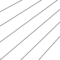

Predicted Label: 0, Real label 0
Probability for class 1: 0.0002


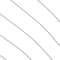

Predicted Label: 1, Real label 1
Probability for class 1: 0.5315


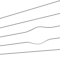

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


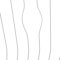

Predicted Label: 0, Real label 0
Probability for class 1: 0.0001


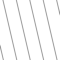

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


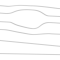

Predicted Label: 1, Real label 1
Probability for class 1: 1.0


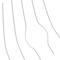

Predicted Label: 0, Real label 1
Probability for class 1: 0.132


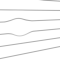

In [155]:
# Ansehen/Auswerten einzelner Beispiele
with torch.no_grad():  # Gradienten Ermittlung für Validation unnötig/gesperrt
    for batch in val_loader:
        imgs, labels = batch
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        results = model(imgs).cpu() # Model ausführen und zurückverlegen des Ergebnisses auf die CPU 
        labels = labels.cpu()

        results = torch.nn.functional.softmax(results, dim=1)  # Umwandeln der Activierung in Wahrscheinlichkeiten
        top_p,top_class = results.topk(1,dim = 1)  # Ermitteln der wahrscheinlicheren Klasse


        for i, img in enumerate(imgs):
            print(f"Predicted Label: {top_class[i].item()}, Real label {labels[i]}")
            print(f"Probability for class 1: {round(results[i][1].item(), 4)}")

            img_unn = (np.transpose(unnormalize_trans(img.cpu().detach()).numpy(), (1, 2, 0)))
            img_unn = Image.fromarray((img_unn * 255).astype(np.uint8))
            #print(f"Bild Nr {nummer}:")
            display(img_unn)  # Anzeigen lassen
    
    del imgs, labels

In [156]:
# Grafikkartenspeicher aufräumen falls nötig, wenn beispielsweise unterbrochen wurde und nicht alles gelöscht wurde
import gc  # garbage collect

#torch.cuda.memory_summary(device=device, abbreviated=False)
torch.cuda.empty_cache()
gc.collect()

7772